# Imports

In [ ]:
!pip install keras-lr-finder

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from keras_lr_finder import LRFinder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import SCORERS, confusion_matrix, classification_report
from sklearn import preprocessing
import random
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)
print(tf.__version__)

2.5.0


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# datafolder: https://github.com/LesiaR/Datasets-base/tree/main/dt

# Functions

In [ ]:
# few function for plotting metrics
def plot_metric(hist, metric, ylim):
  plt.plot(hist.history[f'{metric}'])
  plt.plot(hist.history[f'val_{metric}'])
  plt.title(f'Model {metric}')
  plt.ylabel(f'{metric}')
  plt.xlabel('epoch')
  plt.ylim(ylim)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def plot_metrics_rg(hist, metric1, metric2, ylim1=[-0.1,1], ylim2=[-0.1, 1]):
  plot_metric(hist, metric1, ylim1)
  plot_metric(hist, metric2, ylim2)

def plot_metrics(hist, metric1, metric2):
  pyplot.subplot(211)
  pyplot.title(f'{metric1}')
  pyplot.plot(hist.history[f'{metric1}'], label='train')
  pyplot.plot(hist.history[f'val_{metric1}'], label='test')
  pyplot.legend()

  pyplot.subplot(212)
  pyplot.title(f'{metric2}')
  pyplot.plot(hist.history[f'{metric2}'], label='train')
  pyplot.plot(hist.history[f'val_{metric2}'], label='test')
  pyplot.legend()
  pyplot.show()

In [ ]:
# Class for MultiColumnLabelEncoding
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [ ]:
# Function for classification report and confusion matrix
def report(y_test, y_pred):
    print('\n====classification report:====')
    print(classification_report(y_test, y_pred))

    print('\n====confusion matrix====')
    labels = [0, 1, 2]
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=confusion_matrix(y_test, y_pred),
                xticklabels=labels,
                yticklabels=labels,
                cmap='coolwarm');
    plt.ylabel('True')
    plt.xlabel('Predicted')

# Regression task

## Data description
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. 

The device was located on the field in a significantly polluted area, at road level,within an Italian city. 

Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses.

 Missing values are tagged with -200 value.

 **C6H6** True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) -> **Target variable**


## Read data and some preprocessing

In [ ]:
# setting the path through keras
dataset_path = keras.utils.get_file("AirQualityUCI.csv", "https://raw.githubusercontent.com/LesiaR/Datasets-base/main/AirQualityUCI.csv")

In [ ]:
# Reading the data
raw_dataset = pd.read_csv(dataset_path, sep = ';', na_values=-200, decimal = ',')
raw_dataset

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As wider EDA and analysis was done in the Regression module, so only short explanation will be written here.

In [ ]:
# Percentage of missing values for each feature
data = raw_dataset.copy()
data.isna().sum()/len(data)

Date             0.012037
Time             0.012037
CO(GT)           0.189737
PT08.S1(CO)      0.050681
NMHC(GT)         0.903495
C6H6(GT)         0.050681
PT08.S2(NMHC)    0.050681
NOx(GT)          0.185091
PT08.S3(NOx)     0.050681
NO2(GT)          0.185408
PT08.S4(NO2)     0.050681
PT08.S5(O3)      0.050681
T                0.050681
RH               0.050681
AH               0.050681
Unnamed: 15      1.000000
Unnamed: 16      1.000000
dtype: float64

In [ ]:
# Dropping rows filled with NaNs and 1 column which has >90% NaNs
data.drop(['Unnamed: 15','Unnamed: 16','NMHC(GT)'], axis = 1, inplace = True)

# Dropping NaNs ros for target
data.drop(data[data['C6H6(GT)'].isnull()].index, axis = 0, inplace = True)

In [ ]:
# Parsing and setting DateTime column as index
data.Time = data.Time.str.replace('.',':')
data.Date = data["Date"]+' '+data['Time']
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')
data.drop(['Time'], axis = 1, inplace = True)

In [ ]:
# Dropping rows which has more then 10 NaNs
bad_rows = data[data.shape[1] - data.count(axis=1) > 10].index
data.drop(bad_rows, axis = 0, inplace = True)

In [ ]:
# Dropping some small amount of NaNs left
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6941 entries, 2004-10-03 18:00:00 to 2005-04-04 14:00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         6941 non-null   float64
 1   PT08.S1(CO)    6941 non-null   float64
 2   C6H6(GT)       6941 non-null   float64
 3   PT08.S2(NMHC)  6941 non-null   float64
 4   NOx(GT)        6941 non-null   float64
 5   PT08.S3(NOx)   6941 non-null   float64
 6   NO2(GT)        6941 non-null   float64
 7   PT08.S4(NO2)   6941 non-null   float64
 8   PT08.S5(O3)    6941 non-null   float64
 9   T              6941 non-null   float64
 10  RH             6941 non-null   float64
 11  AH             6941 non-null   float64
dtypes: float64(12)
memory usage: 704.9 KB


## EDA

Main analysis was done in previous module, only some multivariate relations will be checked

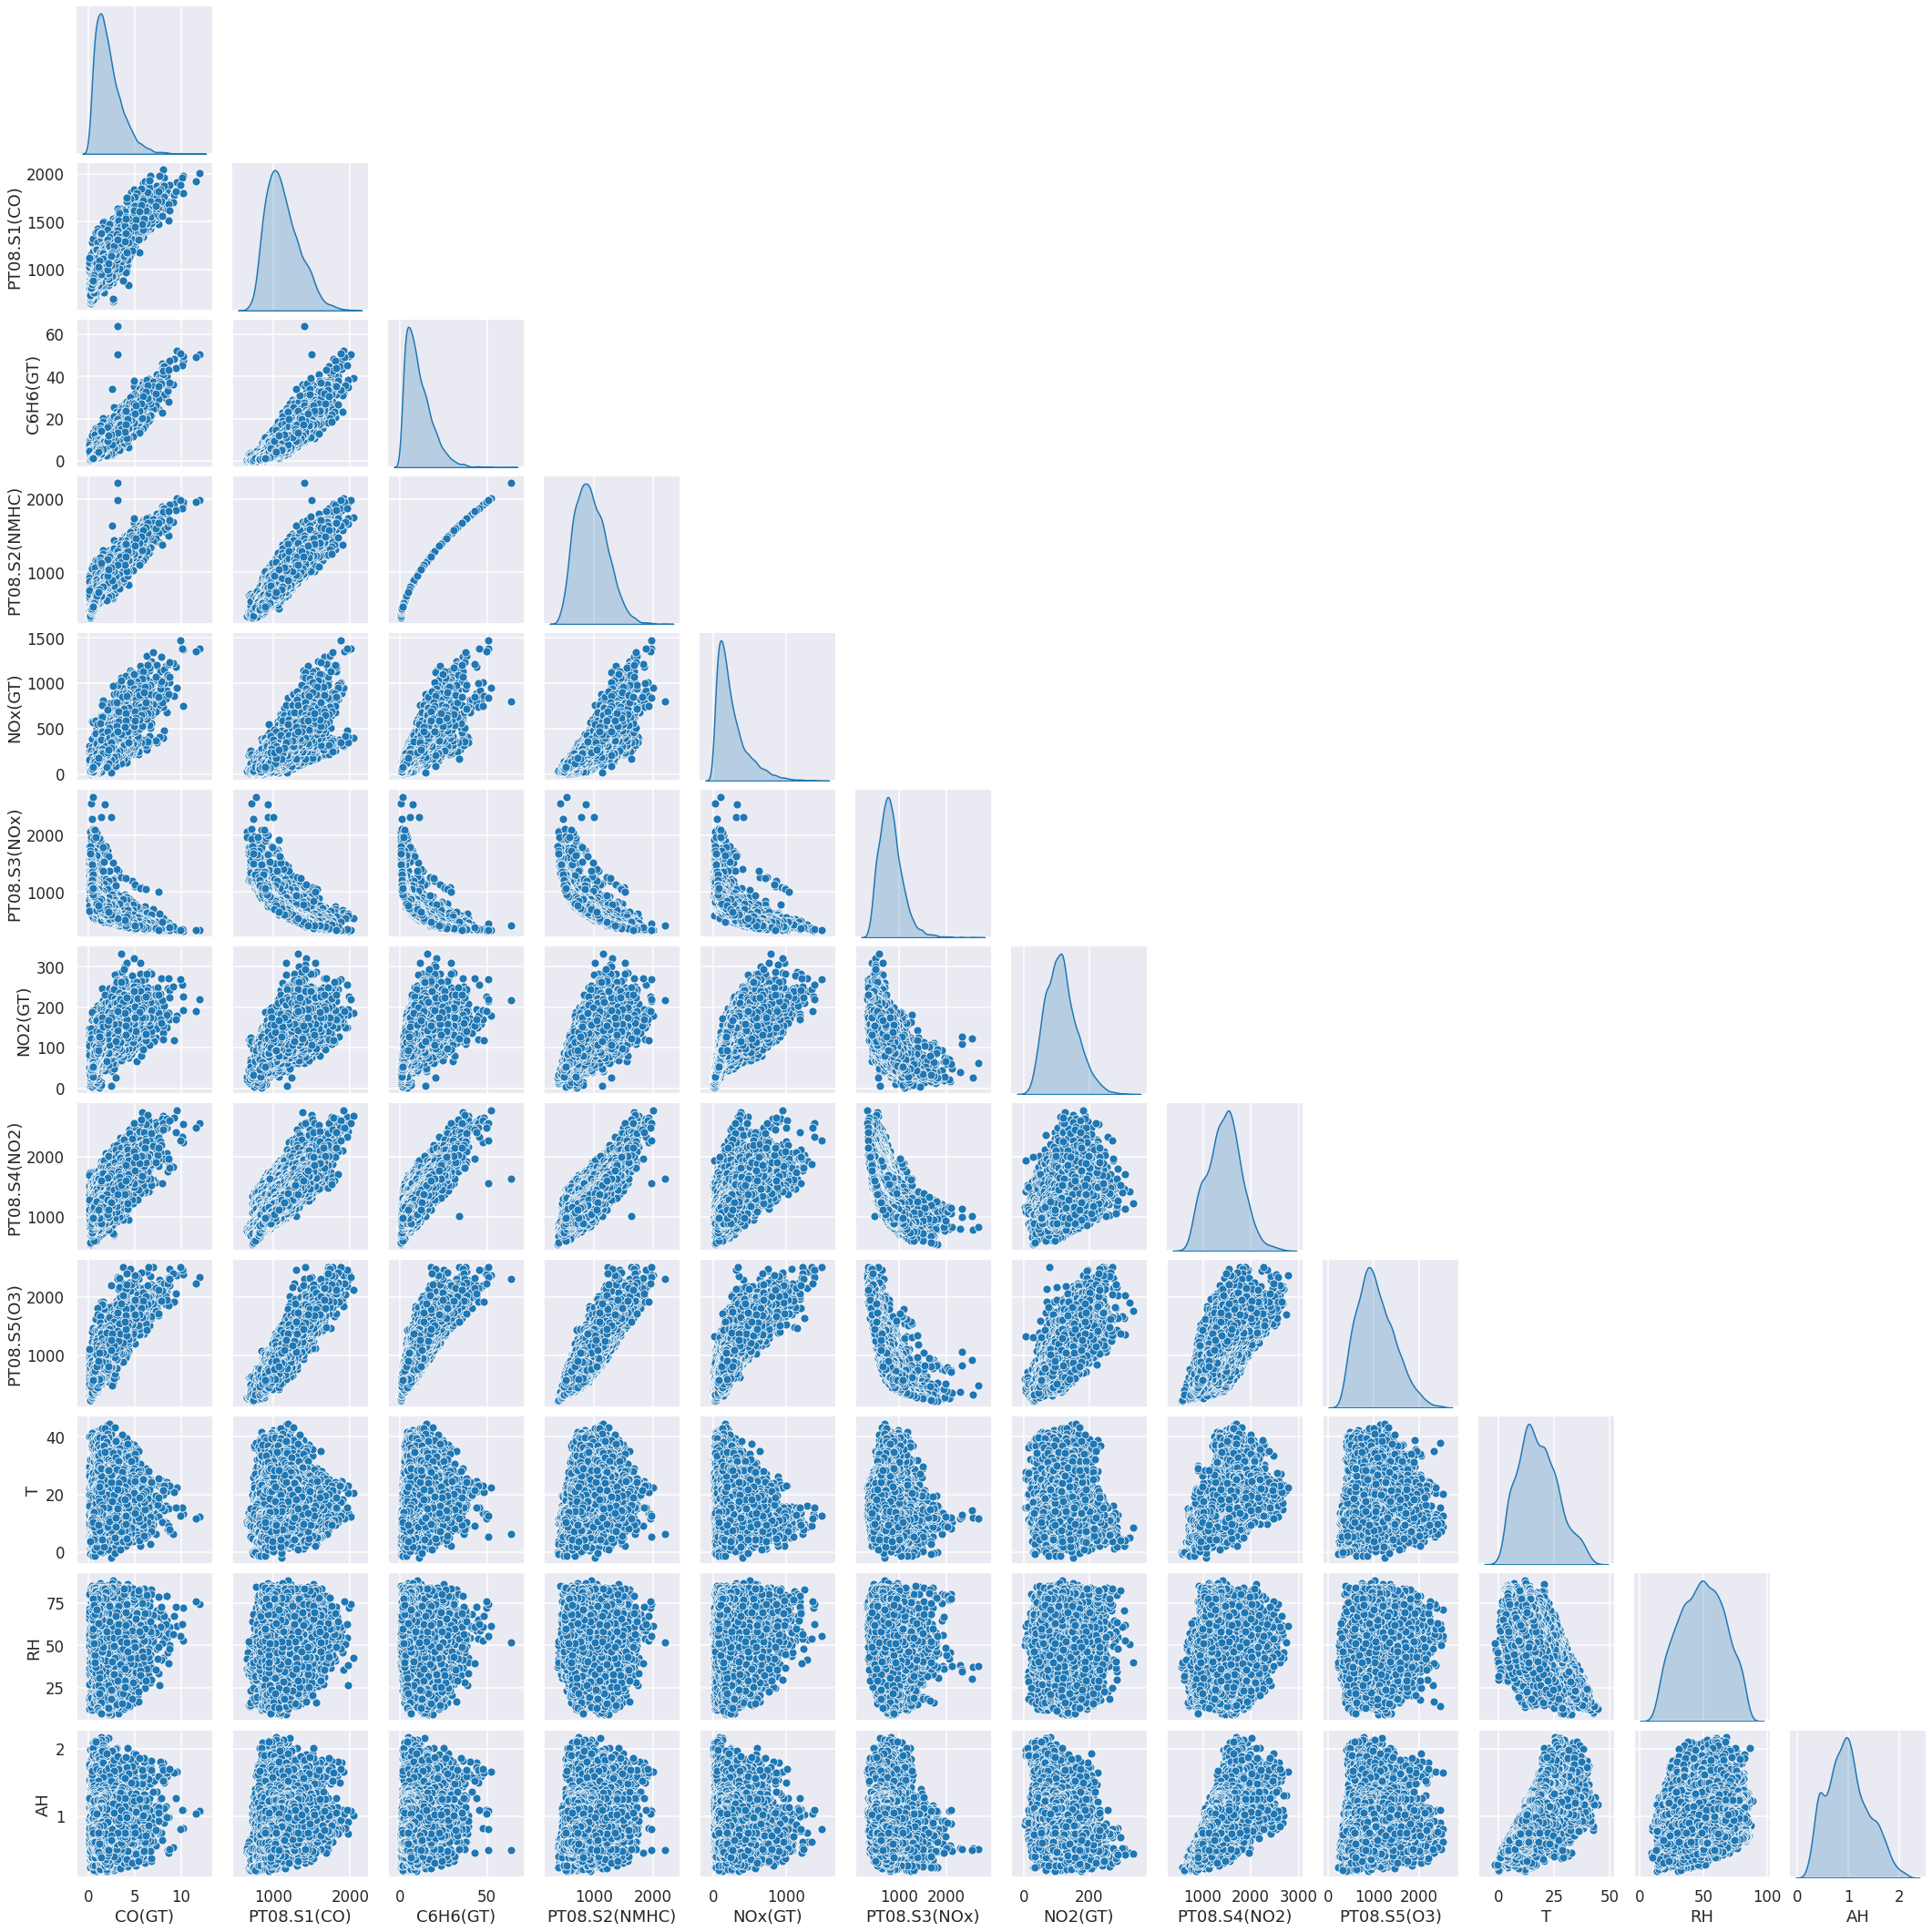

In [ ]:
# Visualization for numerical features relations
sns.pairplot(data, diag_kind="kde", corner=True)

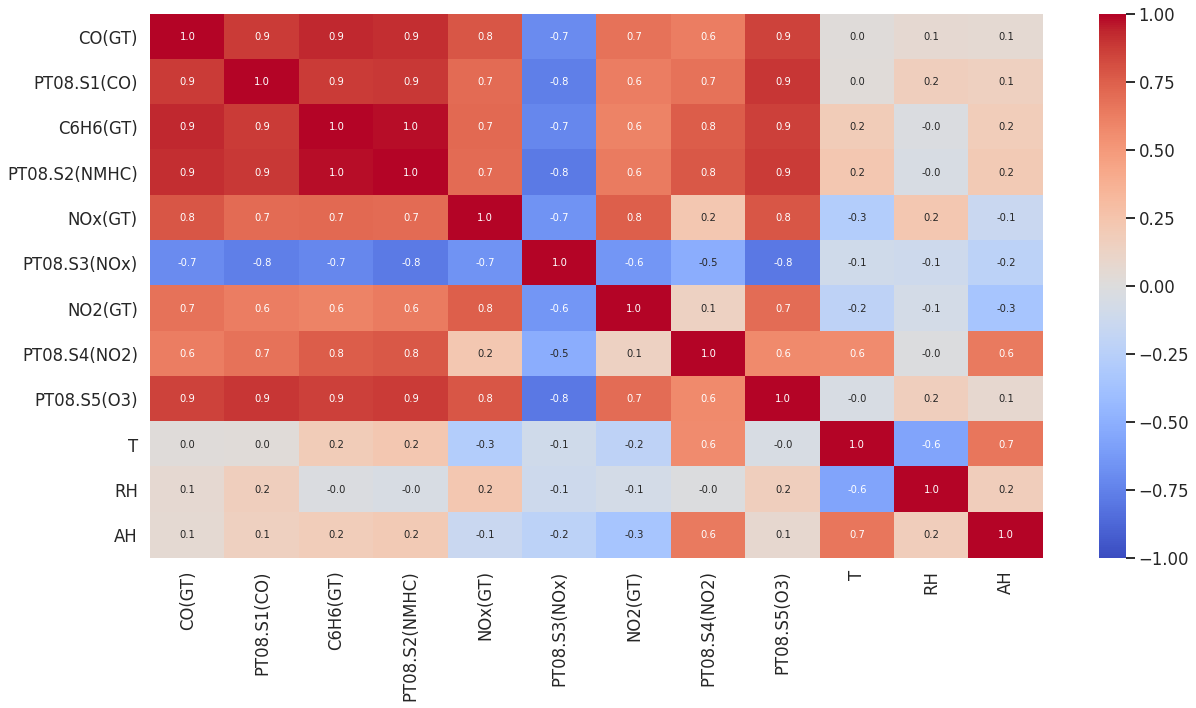

In [ ]:
# Checking correlation
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(data.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm')

In [ ]:
# Dropping some low correlated to target features(noise) and some highly correlated features (to avoid multicolinearity)
data.drop('PT08.S1(CO)', axis=1, inplace=True)
data.drop('PT08.S5(O3)', axis=1, inplace=True)
data.drop('RH', axis=1, inplace=True)
data.drop('AH', axis=1, inplace=True)

## Train/test split

In [ ]:
# Splitting train/test, test ~20% of data, done by indexes as we have timeseries data
data = data.sort_index()
train, test = data.iloc[:5550,:], data.iloc[5550:,:]

In [ ]:
# Separating target
y_tr = train.pop('C6H6(GT)')
y_ts = test.pop('C6H6(GT)')

## Normalization

Normalization is done the same as in Regression module task 

In [ ]:
# Using MinMax scaler for normalization
minmax_scaler = MinMaxScaler()
train_sc = minmax_scaler.fit_transform(train)
test_sc = minmax_scaler.transform(test)

## Model

In [ ]:
# Setting number of initial epochs
epochs = 800

In [ ]:
# Function for building model with simple neural network, compiling with RMSprop optimizer
def reg_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train.columns)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
# Building the model and checking it's summary
model = reg_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the model and saving the history
history = model.fit(train_sc, y_tr, epochs=epochs, validation_split = 0.2, verbose=0)

In [ ]:
# Converting history to dataframe to check some metrics
hist = pd.DataFrame(history.history)
hist.tail(10)

,loss,mae,mse,val_loss,val_mae,val_mse
790,0.018770,0.098916,0.018770,0.003750,0.045967,0.003750
791,0.019229,0.098435,0.019229,0.004320,0.050337,0.004320
792,0.019270,0.101921,0.019270,0.003524,0.042938,0.003524
793,0.018985,0.099589,0.018985,0.049849,0.186869,0.049849
794,0.019515,0.099804,0.019515,0.005807,0.060168,0.005807
795,0.019464,0.098461,0.019464,0.042258,0.163583,0.042258
796,0.020036,0.107129,0.020036,0.005784,0.057480,0.005784
797,0.019399,0.096808,0.019399,0.003370,0.041939,0.003370
798,0.020005,0.101122,0.020005,0.005102,0.051721,0.005102
799,0.019661,0.099304,0.019661,0.003696,0.043889,0.003696


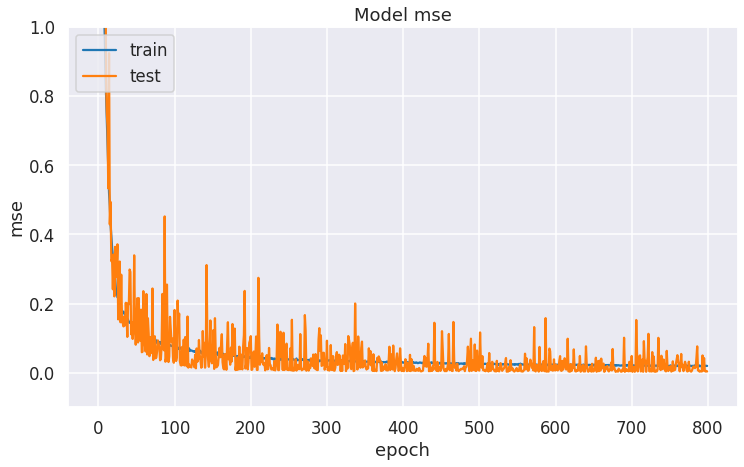

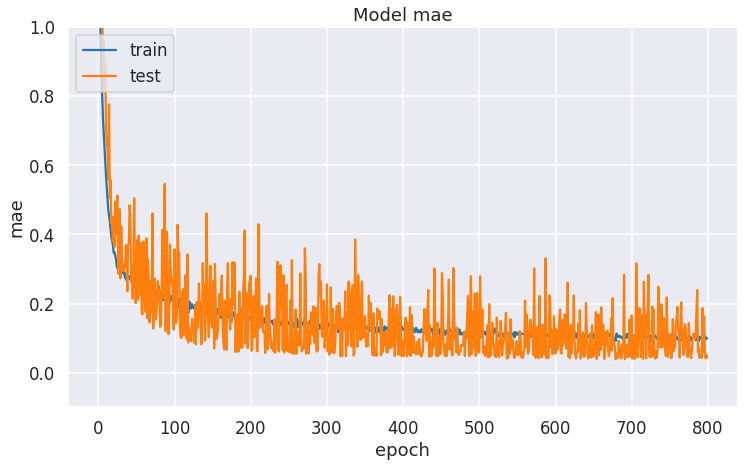

In [ ]:
# Plotting MSE and MAE
plot_metrics_rg(history, 'mse', 'mae')

As we can see MSE and MAE decreases generally for train and val parts while model's training, in the end decreasing is very small, but there is no need to stop it earlier

In [ ]:
# Evaluating the model for Test set of data
loss, mae, mse = model.evaluate(test_sc, y_ts, verbose=0)
y_pred = model.predict(test_sc).flatten()
r2 = r2_score(y_ts, y_pred)
print("Testing set MAE: {:5.4f} ".format(mae))
print("Testing set MSE: {:5.4f} ".format(mse))
print("Testing set R2: {:5.4f} ".format(r2))

Testing set MAE: 0.0420 
Testing set MSE: 0.0030 
Testing set R2: 0.9999 


So our MAE/MSE/R2 are pretty good, they are slightly better then for the same preconditions in simple Linear Regression model. (For LR MSE was 0.008 and R2 0.9900). But as in our case even with 1 feature PT08.S2(NMHC) we can get very good predictions so that's why simple linear model worked good and Neural network didn't change results significantly

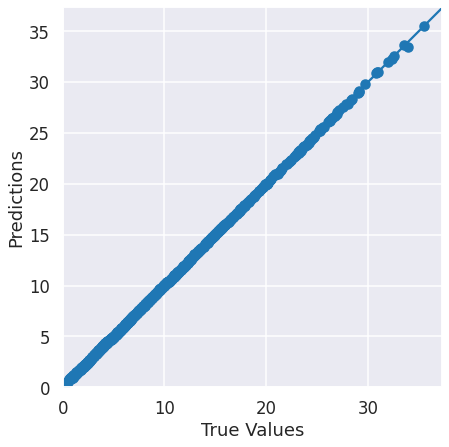

In [ ]:
# Visualization for True vs Predicted value of target
plt.scatter(y_ts, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts values highly correlated with true values which is confirmed by the metrics, so it works very good and can predict correct values 

## Optional: PyTorch - Regression task

Here I've tried to build the same model but with PyTorch

In [ ]:
# Creating class for building the model
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, out_count)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
# Transforming X and y data to tensors   
x_train = Variable(torch.Tensor(np.array(train)).float())
x_test = Variable(torch.Tensor(np.array(test)).float())
y_train = Variable(torch.Tensor(np.array(y_tr)).float())
y_test = Variable(torch.Tensor(np.array(y_ts)).float())

# Instantiating the model, output dimentions is 1
model = Net(len(train.columns), 1)

# Setting loss function
criterion = nn.MSELoss() 

# Setting optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
for epoch in range(100):
    optimizer.zero_grad()
    out = model(x_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, loss: {loss.item()}")

In [ ]:
# Making prediction for test data
pred = model(x_test)

# Converting tensors back to arrays
y_test = y_test.detach().numpy()
pred = pred.detach().numpy()

In [ ]:
# Evaluating the model with R2 and MAE
r2 = r2_score(y_test, pred)
print(f"R2: {r2}")
mae = mean_absolute_error(y_test, pred)
print(f"MAE: {mae}")

R2: 0.12302324215232452
MAE: 4.439943790435791


As you can see for me this this model gave bad results, I assume something was done not totally the same as in tf/keras model, because actually it should work the same.

# Classification task

## Data description

    1. Many attributes (29)
    2. mostly numeric or Boolean valued attributes
    3. thyroid disease domains (records provided by the Garavan Institute
       of Sydney, Australia)
    4. several missing attribute values (signified by "?")
    5. small number of classes (4)-> target
    7. 3771 instances in data set

## Read data and some preprocessing

In [ ]:
# setting the path through keras
dataset_path1 = keras.utils.get_file("dataset_57_hypothyroid.csv", "https://raw.githubusercontent.com/LesiaR/Datasets-base/main/dataset_57_hypothyroid.csv")

In [ ]:
# Reading the data
df = pd.read_csv(dataset_path1, na_values='?')
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.00,t,2.1,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.10,t,1.8,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.70,t,2.0,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative


As wider EDA and analysis was done in the Classification module, so only short explanation will be written here. Preprocessing stays the same.

In [ ]:
# Dropping non-representable variables
df.drop(['TBG','TBG_measured','TSH_measured', 'T3_measured', \
           'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', \
           'hypopituitary'], axis = 1, inplace = True)

# Separating categorical and numerical features
cat_vals = [i for i in df.columns if df.dtypes[i] == 'O']
num_vals = [i for i in df.columns if df.dtypes[i] == 'float64']
cat_vals.remove('Class')

# Dropping outliers
df.drop(df[df.age > 100].index, inplace = True)

# Dropping class secondary_hypothyroid as it is represented only by 2 objects
df.drop(df[df.Class == 'secondary_hypothyroid'].index, inplace = True)

## EDA

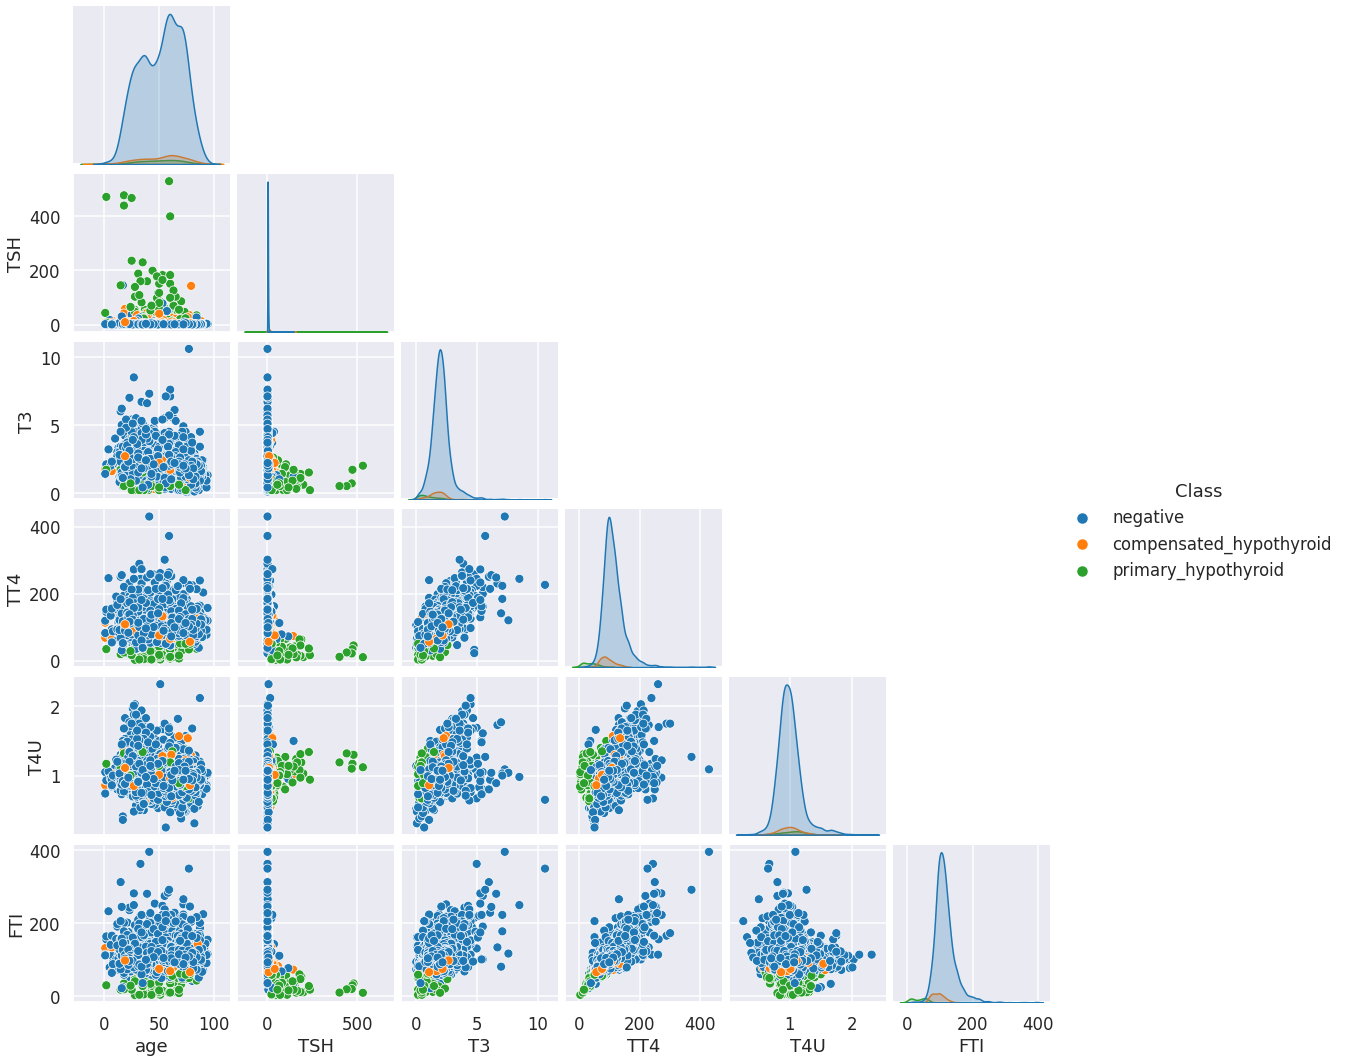

In [ ]:
# Visualization for target vs numerical features relations
sns.pairplot(
    df,
    x_vars=num_vals,
    y_vars=num_vals,
    corner=True,
    hue = 'Class'
)

In [ ]:
# Encoding classes
# To make sure every value is encoded correctly dictionary and map are used, the higher severity, the higher number
vals_to_replace = {'negative': 0, 'compensated_hypothyroid':'1', 'primary_hypothyroid':'2'}
df.Class = df.Class.map(vals_to_replace).astype(int)

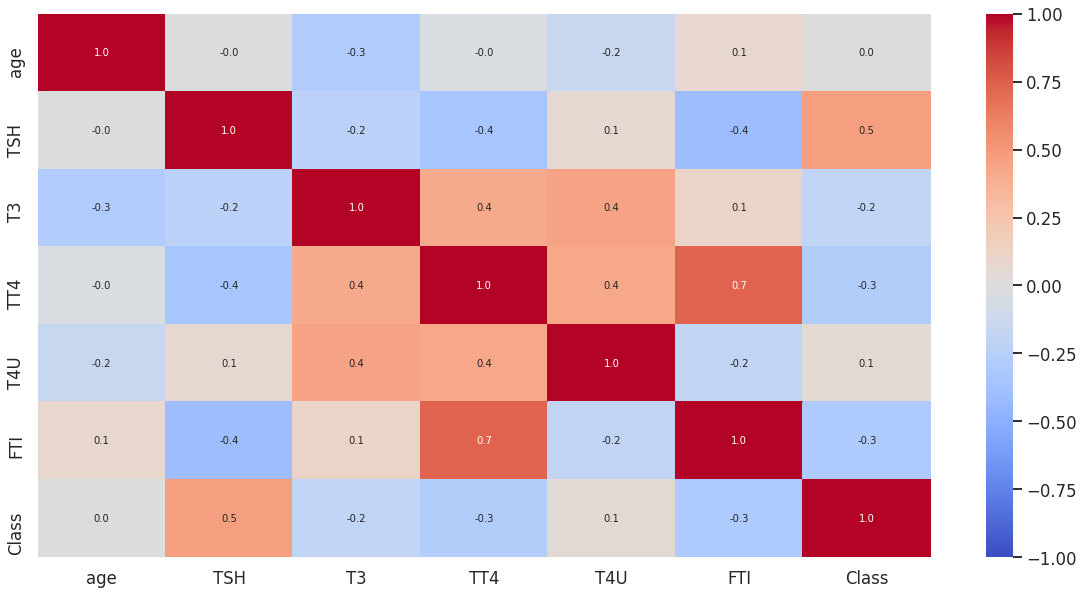

In [ ]:
# Visualization for correlation between numerical features
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(df.corr('spearman'), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm')

## Train/test split

In [ ]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class',axis=1), df.Class, test_size=0.2, stratify = df.Class)

In [ ]:
# Preparing y data fot the model
y_test1 = y_test.copy()
y_train1 = y_train.copy()
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

## Scaling, transformations, encoding

The same scaling, transformations and encoding will be done as in Classification module

In [ ]:
# Imputing missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant',fill_value='unknown')

X_train[num_vals] = num_imputer.fit_transform(X_train[num_vals])
X_train.sex = cat_imputer.fit_transform(X_train.sex.values.reshape(-1, 1))
X_test[num_vals] = num_imputer.transform(X_test[num_vals])
X_test.sex = cat_imputer.transform(X_test.sex.values.reshape(-1, 1))

In [ ]:
# Scaling with RobustScaler
vals_to_scale = [x for x in num_vals if x!='TSH']
robust_scaler = RobustScaler()
X_train[vals_to_scale] = robust_scaler.fit_transform(X_train[vals_to_scale])
X_test[vals_to_scale] = robust_scaler.transform(X_test[vals_to_scale])

In [ ]:
# Log transformation for TSH feature
X_train.TSH = np.log(X_train.TSH)
X_test.TSH = np.log(X_test.TSH)

In [ ]:
# Label encoding for multiple columns
mle = MultiColumnLabelEncoder(columns = cat_vals)
X_train = mle.fit_transform(X_train)
for i in ['sex', 'referral_source']:
    cols = pd.get_dummies(X_train[i], prefix = i)
    X_train.drop(i, axis = 1, inplace=True)
    X_train = pd.concat([X_train,cols], axis = 1)

X_test = mle.transform(X_test)
for i in ['sex', 'referral_source']:
    cols = pd.get_dummies(X_test[i], prefix = i)
    X_test.drop(i, axis = 1, inplace=True)
    X_test = pd.concat([X_test,cols], axis = 1)


## Model

In [ ]:
# Define the keras model
model = Sequential()
model.add(Dense(64, input_dim=27, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit the keras model on the dataset
epochs = 50
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.998, Test: 0.985


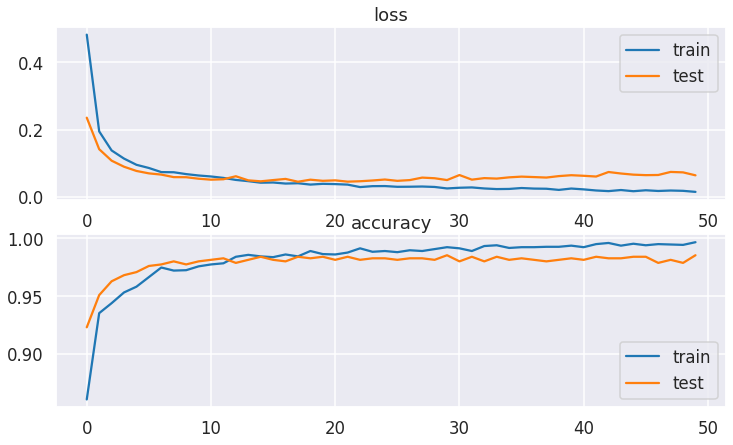

In [ ]:
plot_metrics(history, 'loss', 'accuracy')

As we can see after appr.33-43 epochs accuracy starts descreasing and loss also increasing for the model


====classification report:====
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       696
           1       0.86      0.95      0.90        39
           2       0.94      0.79      0.86        19

    accuracy                           0.99       754
   macro avg       0.93      0.91      0.92       754
weighted avg       0.99      0.99      0.99       754


====confusion matrix====


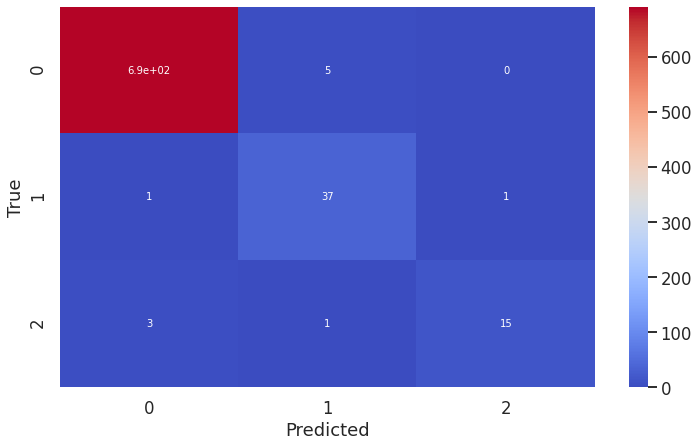

In [ ]:
# make class predictions with the model and checking classification report
y_pred = model.predict_classes(X_test)
report(y_test1, y_pred)

As we can compare to the model from Classification module task Neural network has better results for total accuracy (0.99 vs 0.97) and much better metrics for 0 and 2 class. For 1 class metrics become slightly better, but we should remember that this dataset is very unbalanced and with bigger amount of data results could be improved and still they are very good as we can see on confusion matrix.

## Optional: PyTorch - Classification task

Here I've tried to build the same model but with PyTorch

In [ ]:
# Creating class for building the model
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 64)
        self.fc2 = nn.Linear(64, 32)
        # self.dr = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(32, out_count)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return self.softmax(x)
    
# Transforming X and y data to tensors      
x_train = Variable(torch.Tensor(np.array(X_train)).float())
x_test = Variable(torch.Tensor(np.array(X_test)).float())
y_train = Variable(torch.LongTensor(np.array(y_train1)))
y_test = Variable(torch.LongTensor(np.array(y_test1)))

# Instantiating the model, output dimentions is 3 as we have 3 classes
model = Net(len(X_train.columns), 3)

# Setting loss function
criterion = nn.CrossEntropyLoss()

# Setting optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Training the model
for epoch in range(100):
    optimizer.zero_grad()
    out = model(x_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, loss: {loss.item()}")

In [ ]:
# Making prediction for test data
pred = model(x_test)
_, predict_classes = torch.max(pred, 1)

# Evaluating the model
correct = accuracy_score(y_test1,predict_classes)
print(f"Accuracy: {correct}")

Accuracy: 0.9230769230769231


Score is pretty good but still worth then for tf/keras model

# Computer Vision task

## Baseline model

We have already images devided onto the folders train and test, and within every folder onto hot dog/not hot dog, so we just define the path


In [ ]:
# Defining some basic values which will be used in the section
w = 150 # width of input image
h = 150 # height of input image
tr_dir = 'gdrive/MyDrive/Mine/Automation/dt/train'
ts_dir = 'gdrive/MyDrive/Mine/Automation/dt/test'
n_tr = 498
n_val = 500
epochs = 50
batch_size = 50

In [ ]:
# Setting format for image data
if K.image_data_format() == 'channels_first':
  input_shape = (3, w, h)
else:
  input_shape = (w, h, 3)

### Image augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. This helps to prevent overfitting and the model generalizes better. 

In our case next options will be used:

In [ ]:
# Augmentation configuration used for training
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescaling
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2, # shear transformation
        zoom_range=0.2, # zooming 
        horizontal_flip=True, # flipping horizontally
        fill_mode='nearest') # how to fill in new pixels

# Augmentation configuration used for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Generating batches of randomly transformed images for train and test data
tr_generator = train_datagen.flow_from_directory(
        tr_dir,
        target_size=(w, h),
        batch_size=batch_size,
        class_mode='binary') 

val_generator = test_datagen.flow_from_directory(
        ts_dir,
        target_size=(w, h),
        batch_size=batch_size,
        class_mode='binary') 

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Model with convolutional layers

Here will be used CNN with 3 convolution layers with a ReLU activation and followed by max-pooling layers. Also will be used Dropout to help prevent overfitting (as well as image augmentation) 

Also we have 2 fully-connected layers a sigmoid activation in the end, which is good for a binary classification. 

As we have binary task and accuracy as metric corresponding values were selected for compiling, and optimimizer RMSprop

In [ ]:
# Building the model and checking summary
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)       

In [ ]:
# Fitting the model
history = model.fit_generator(
        tr_generator,
        steps_per_epoch=n_tr // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=n_val // batch_size)

model.save_weights('first_try.h5') # saving weights

In [ ]:
# Evaluating the model
model.evaluate(val_generator)

10/10 [==============================] - 2s 210ms/step - loss: 0.6597 - accuracy: 0.6300


[0.6597115993499756, 0.6299999952316284]

As we can see accuracy is pretty low, we can try to improve it with some other image augmentations or increasing number of hidden layers, also pretrained models can be used as we have small amount of train data.

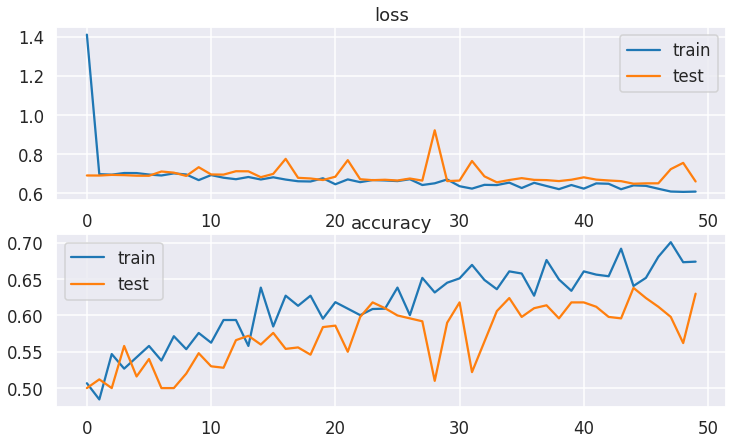

In [ ]:
# Visualization of metrics during training
plot_metrics(history, 'loss', 'accuracy')

As we can see Accuracy stops increasing  and loss is the smalles for test data appr. on 44 epochs, but for 50 epochs difference is not big so it will stay as it is.

## Pretrained models

Few pretrained model will be checked (VGG16, ResNet50, InceptionV3) and one with better acuuracy will be used for Unfeezing the layers and finding optimal learning rate

### VGG16

In [ ]:
# We build the base VGG16 model 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before (transfer learning)
for layer in base_model.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

# We take the last layer of our the model and add it to our classifier
last = base_model.layers[-1].output
x = layers.Flatten()(last)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Training obtained model
vgg_history = model.fit_generator(tr_generator, validation_data = val_generator, steps_per_epoch = n_tr//batch_size, epochs = epochs, verbose=0)

In [ ]:
# Evaluating the model
model.evaluate(val_generator)

10/10 [==============================] - 3s 246ms/step - loss: 0.5951 - accuracy: 0.7740


[0.5950546860694885, 0.7739999890327454]

So for pretrained VGG16 model we have better result then for baseline CNN model, let's check some other models

### ResNet50

In [ ]:
# Base ResNet50 model
base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

In [ ]:
# Freezing all model's layers and adding classifier
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

#Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Fitting the model
resnet_history = model.fit_generator(tr_generator, validation_data = val_generator, steps_per_epoch = 10, epochs = epochs, verbose=0)

In [ ]:
# Evaluating the model
model.evaluate(val_generator)

10/10 [==============================] - 2s 238ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931486129760742, 0.5]

As we can see for this model Acuuracy is low so will not use it in the next section. Let's check last pretrained model.

### InceptionV3

In [ ]:
# Base InceptionV3 model
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

In [ ]:
# Freezing all model layers and adding classifier
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)
model.summary()

# Compiling obtained model
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Training the model
inc_history = model.fit_generator(tr_generator, validation_data = val_generator, steps_per_epoch = n_tr//batch_size, epochs = epochs, verbose =0)

In [ ]:
# Evaluating the model
model.evaluate(val_generator)

10/10 [==============================] - 2s 239ms/step - loss: 0.3835 - accuracy: 0.8560


[0.3835495114326477, 0.8560000061988831]

As we can see for this model Acuuracy is the best one so will use it in next sections

Also visualization for metrics will be checked

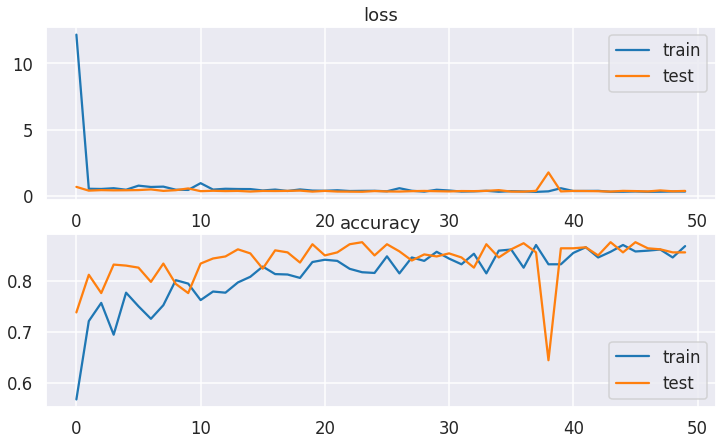

In [ ]:
# Visualization of metrics during training
plot_metrics(inc_history, 'loss', 'accuracy')

So we can see we could stop training on appr.23 epochs, but as difference is not big, so for now it will stay as it is.

### Unfreeze pretrained model layers - InceptionV3

Now few layers of InceptionV3 model will be unfreezed to see if it can improve the result

In [ ]:
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

In [ ]:
# Unfreezing few last layers - name of layer is from model summary in previous section
for layer in base_model.layers:
  if layer.name == 'mixed9_1':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

# We add our classificator to the last layer of the model
last = base_model.layers[-1].output
x1 = layers.Flatten()(last)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Dense(1, activation='sigmoid')(x1)
model = Model(base_model.input, x1)

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# New structure of the model
model.summary()

Now we can see that only layers to activation_273 are frozen, all other from mixed9_1 are not.

In [ ]:
# Train the model with last unfreezed layers
inc_history_unfr = model.fit_generator(tr_generator, validation_data = val_generator, steps_per_epoch = n_tr//batch_size, epochs = epochs, verbose=0)

In [ ]:
# Evaluating the model
model.evaluate(val_generator)

10/10 [==============================] - 2s 235ms/step - loss: 0.3503 - accuracy: 0.8620


[0.3502514660358429, 0.8619999885559082]

As we can see after unfreezing we've got slightly better result if to compare with freezed InceptionV3 model.

As we have small amount od data we didn't do unfeeze for a lot of layers, obtained result is good enough. 

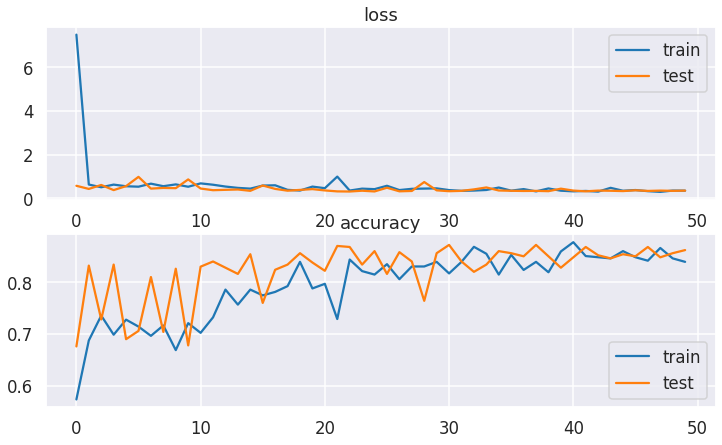

In [ ]:
# Visualization of metrics during training
plot_metrics(inc_history_unfr, 'loss', 'accuracy')

So we can see we could stop training on appr.37 epochs, where accuracy is the biggest for test set, but the difference is not big and results still would be almost the same.

### Best learning rate

To find best learning rate keras-lr-finder will be used, with it help we can obtain plot where optimal learning rate can be selected.

First we need to prepare data correctly.

In [ ]:
# Function for creating image datasets and labels
def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (h, w),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

In [ ]:
# extract the image array and class name
img_tr, classes_tr =create_dataset(r'gdrive/MyDrive/Mine/Automation/dt/train')
img_ts, classes_ts =create_dataset(r'gdrive/MyDrive/Mine/Automation/dt/test')

In [ ]:
# Encoding classes to integer values
target_dict = {'hot_dog': 1, 'not_hot_dog': 0}
train_labels =  [target_dict[classes_tr[i]] for i in range(len(classes_tr))]
test_labels = [target_dict[classes_ts[i]] for i in range(len(classes_ts))]

In [ ]:
# Our optimal preptrained model
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, x)
model.summary()

In [ ]:
# Defining the range of LR
start_lr = 0.00001
end_lr = 1
moving_average = 20

# Determine tests you want to perform
tests = [
  (Adam(), 'Adam optimizer'),
  (RMSprop(), 'RMSprop optimizer')
]

# Set containers for tests
test_learning_rates = []
test_losses = []
test_loss_changes = []
labels = []

In [ ]:
# Perform each test
for test_optimizer, label in tests:

  # Compile the model
  model.compile(optimizer=test_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  # Instantiate the LR Finder
  lr_finder = LRFinder(model)

  # Perform the Learning Rate Range Test
  x=np.array(img_ts, np.float32)
  y=np.array(list(map(int,test_labels)), np.float32)
  outputs = lr_finder.find(x, y, start_lr=start_lr, end_lr=end_lr, batch_size=30, epochs=20)

  # Get values
  learning_rates  = lr_finder.lrs
  losses          = lr_finder.losses
  loss_changes = []

  # Compute smoothed loss changes
  for i in range(moving_average, len(learning_rates)):
    loss_changes.append((losses[i] - losses[i - moving_average]) / moving_average)

  # Append values to container
  test_learning_rates.append(learning_rates)
  test_losses.append(losses)
  test_loss_changes.append(loss_changes)
  labels.append(label)

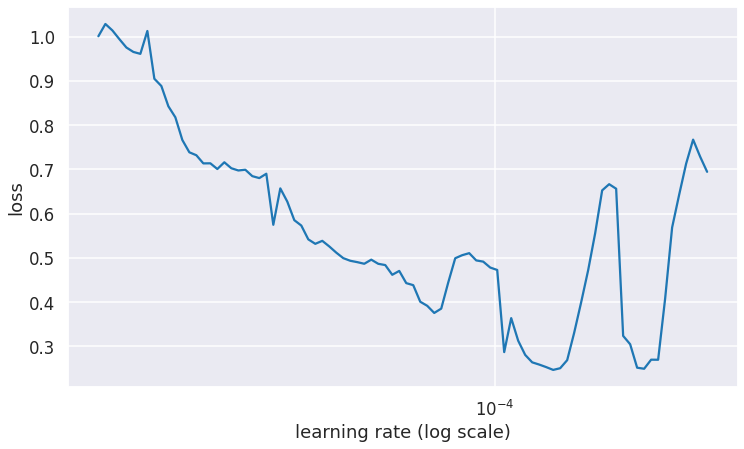

In [ ]:
# Plotting total losses
lr_finder.plot_loss()

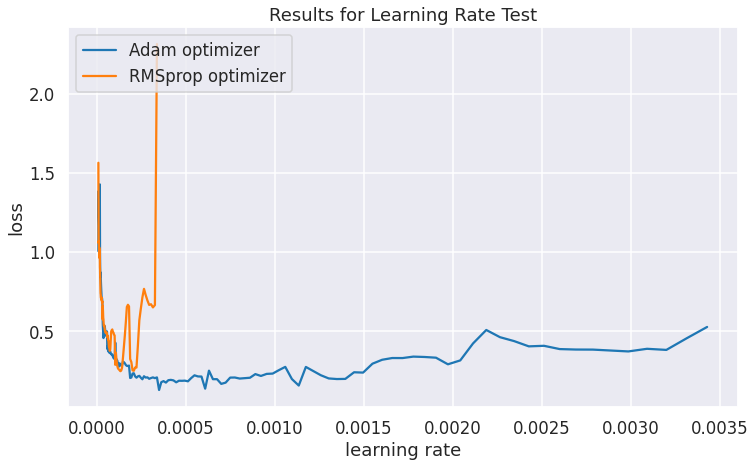

In [ ]:
# Generate plot for loss values for different optimizers
for i in range(0, len(test_learning_rates)):
  plt.plot(test_learning_rates[i], test_losses[i], label=labels[i])
# plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('loss')
plt.xlabel('learning rate')
plt.title('Results for Learning Rate Test')
plt.show()


As we can see from the plot the best optimizer is Adam optimazer with learning rate 0.00035 or 0.0006

## Conclusions:
* Different models were used for CV task and some pretrained models showed very good results
* Optimal pretrained model was InceptionV3 and after unfreezing few last layers result become even slightly better.
* Also best optimizer with learning rate was selected for pretrained model.